### Importing Libraries

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import optimizers, regularizers, Model
from keras.applications import densenet
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import pickle
import os
from os import listdir
from os.path import isfile, join 
import cv2

### Model Setting

In [2]:
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

BATCH_SIZE = 15
EPOCHS = 20
STEP_PER_EPOCHS = 50

### Load Image Dataset

In [3]:
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
predict_dir = os.path.join(base_dir, 'predict')

### Creating Objects for Image Augmentations

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=True,
                            rotation_range=30,
                            width_shift_range=0.3,
                            height_shift_range=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                    target_size=IMAGE_SIZE,
                                    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(test_dir,
                                    target_size=IMAGE_SIZE,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

Found 2062 images belonging to 5 classes.
Found 408 images belonging to 5 classes.


### Image Augmentations Results

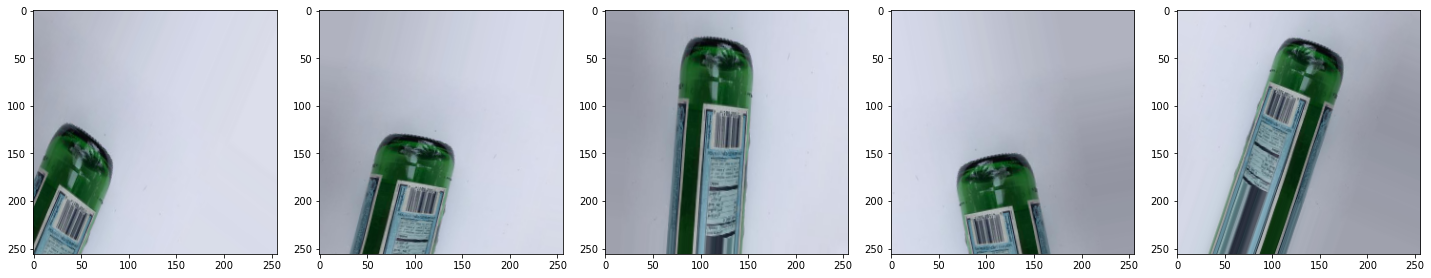

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Load DenseNet121 model with ImageNet weights

In [6]:
base_model = densenet.DenseNet121(include_top=False,weights='imagenet',
                           input_tensor=None,input_shape=INPUT_SHAPE,pooling='max')

In [7]:
x = base_model.output

x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Compiling the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Fitting Model

In [9]:
STEP_PER_EPOCHS = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = test_generator.n//test_generator.batch_size

model_history = model.fit(train_generator,
                steps_per_epoch=STEP_PER_EPOCHS, epochs=EPOCHS,
                validation_data=test_generator, validation_steps=STEP_SIZE_VALID,
                callbacks=[EarlyStopping(monitor='loss',patience=3,verbose=1)])

Epoch 1/20
137/137 [==============================] - 736s 5s/step - loss: 1.3552 - accuracy: 0.4362 - val_loss: 1.2744 - val_accuracy: 0.4741
Epoch 2/20
137/137 [==============================] - 756s 6s/step - loss: 0.9088 - accuracy: 0.6639 - val_loss: 0.8765 - val_accuracy: 0.6790
Epoch 3/20
137/137 [==============================] - 768s 6s/step - loss: 0.7282 - accuracy: 0.7396 - val_loss: 0.6444 - val_accuracy: 0.7827
Epoch 4/20
137/137 [==============================] - 764s 6s/step - loss: 0.6316 - accuracy: 0.7826 - val_loss: 0.4917 - val_accuracy: 0.8198
Epoch 5/20
137/137 [==============================] - 845s 6s/step - loss: 0.5589 - accuracy: 0.8021 - val_loss: 0.4356 - val_accuracy: 0.8494
Epoch 6/20
137/137 [==============================] - 786s 6s/step - loss: 0.4959 - accuracy: 0.8300 - val_loss: 0.3704 - val_accuracy: 0.8815
Epoch 7/20
137/137 [==============================] - 752s 5s/step - loss: 0.4587 - accuracy: 0.8412 - val_loss: 0.3107 - val_accuracy: 0.9062

In [9]:
Densemodel = keras.models.load_model("DenseNet121.h5")

### Model Accuracy and Loss Plots

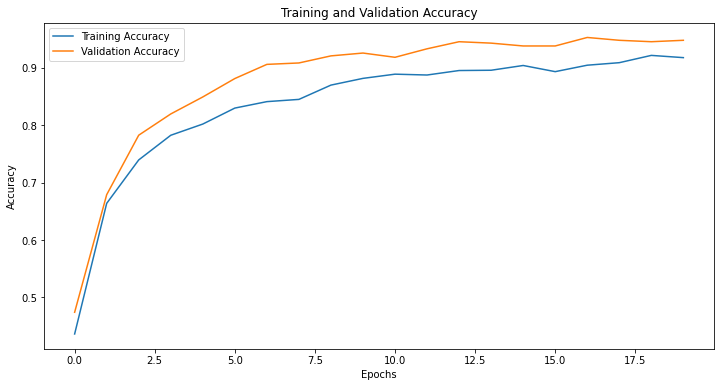

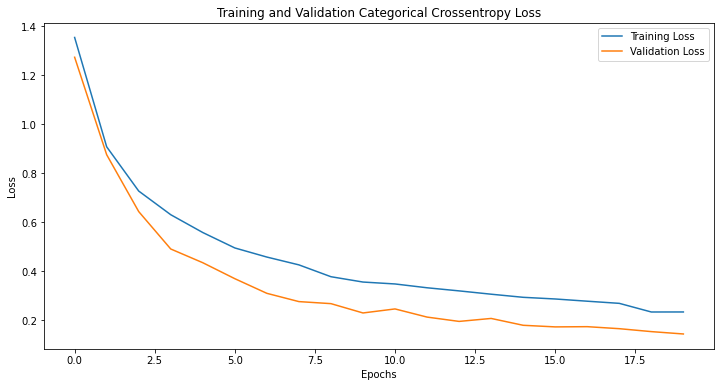

In [10]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation Accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and Validation Categorical Crossentropy Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


model_performance_plot(model_history)

### Evaluate Test Dataset

In [10]:
loss, accuracy = Densemodel.evaluate(test_generator, steps=test_generator.samples//test_generator.batch_size)

27/27 [==============================] - 26s 917ms/step - loss: 0.1447 - accuracy: 0.9481


In [12]:
print("Test dataset Accuracy: %f and Loss: %f" % (accuracy,loss))

Test dataset Accuracy: 0.948148 and Loss: 0.144747


### Model Classification and Confusion Matrix

In [11]:
Y_pred = Densemodel.predict(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

In [14]:
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))    

              precision    recall  f1-score   support

   cardboard       0.98      0.99      0.98        80
       glass       0.93      0.94      0.93        80
       metal       0.96      0.94      0.95        84
       paper       0.96      0.96      0.96        80
     plastic       0.90      0.90      0.90        84

    accuracy                           0.95       408
   macro avg       0.95      0.95      0.95       408
weighted avg       0.95      0.95      0.95       408



<AxesSubplot:>

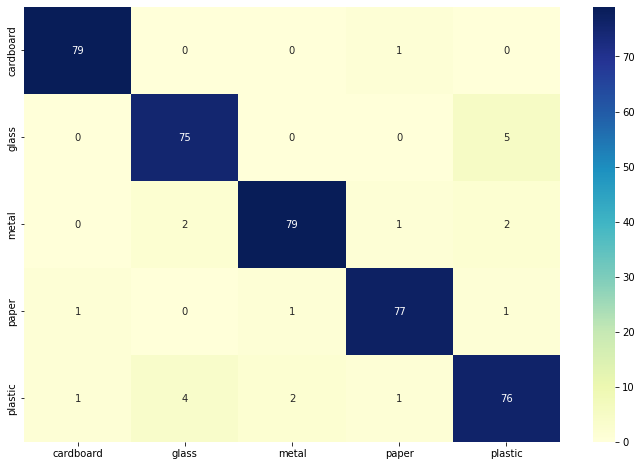

In [15]:
conf_mat = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

### Predict New Images

In [12]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}

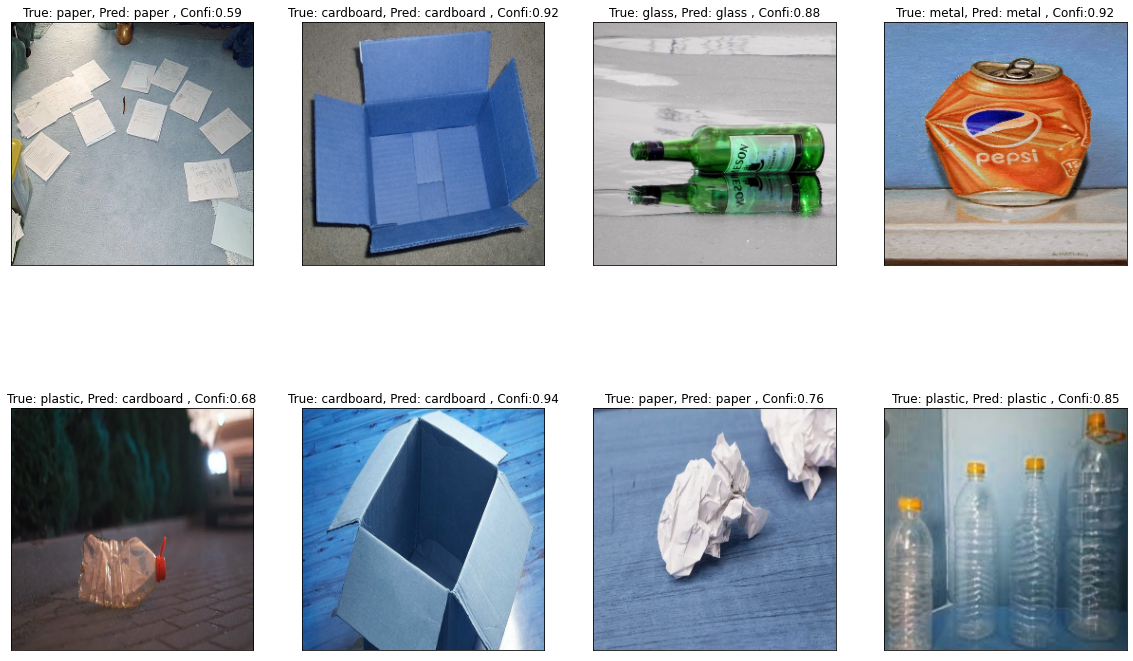

In [14]:
def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    elif "cardboard" in filename:
        return 'cardboard'
    

def plot_predicted_label(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 13))
    
    rs = np.random.choice(len(onlyfiles),nrows*ncols,replace=False)
    
    for i, ax in zip(rs, axes.flat):
        img = cv2.imread(os.path.join(predict_dir, onlyfiles[i]))
        true_type = image_type(onlyfiles[i])
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1])) 
        img = img /255
         
        probabilities = Densemodel.predict(np.asarray([img]))[0]
        class_idx = np.argmax(probabilities)
            
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,class_mapping[class_idx],probabilities[class_idx])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
num_rows = 2
num_cols = 4

# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

plot_predicted_label(num_rows, num_cols,onlyfiles);

### Save Model

In [18]:
model.save('DenseNet121.h5')